## Imports

In [2]:
# Pytorch specific imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2

# Other imports
import kaggle
import albumentations as A # - This was installed via pip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

## Setup Neural Networks

In [3]:
# This ConvNet could be used instead of the "ComplexCNN". It has less layers, and likely can detect less features, but is also less likely to overfit and faster
class SimpleCNN(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.dropout_conv = nn.Dropout(p=dropout_prob/2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)  # For binary classification

        self.dropout_fc = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        # Flatten
        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

In [4]:
# This ConvNet is more complex with more layers than the "standard" ConvNet defined above
class ComplexCNN(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(ComplexCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.dropout_conv = nn.Dropout(p=dropout_prob/2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)  # For binary classification

        self.dropout_fc = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        # Flatten
        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout_fc(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.dropout_fc(x)
        x = F.leaky_relu(self.fc4(x))
        x = self.dropout_fc(x)
        x = self.fc5(x)

        return x

## Set Up Device Agnostic Code

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Hyperparamters

In [6]:
input_size = 784
num_classes = 10
learning_rates = [0.0005, 0.005]
batch_size = 64
num_epochs = 12

## Data
- Load Data
- Split Data
- Apply transformations

In [7]:
class AlbumentationsTransform:
    def __init__(self, transform=None):
        self.transform = transform

    def __call__(self, image):
        # Convert PIL image to numpy array
        image_np = np.array(image)

        # Apply transformations
        augmented = self.transform(image=image_np)

        # Convert numpy image back to PyTorch tensor, normalize and permute
        image_tensor = torch.tensor(augmented['image'], dtype=torch.float32).permute(2, 0, 1) / 255.0

        return image_tensor

In [8]:
# Using data augmentation with the albumentations library
augmentation_complex = A.Compose([
    A.Resize(128, 128),
    A.RandomBrightnessContrast(p=0.3),
    A.RandomGamma(p=0.3),
    A.CLAHE(p=0.3),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.GaussNoise(p=0.1),
    A.GaussianBlur(p=0.1),
    A.OpticalDistortion(p=0.05),
    A.GridDistortion(p=0.05),
    # A.ToTensorV2()  # Convert the image to PyTorch tensor. It should be the last transform.
])

augmentation_simple = A.Compose([
    A.Resize(128, 128),
    A.RandomBrightnessContrast(p=0.1),
    A.RandomGamma(p=0.2),
    A.CLAHE(p=0.2),
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=8, p=0.3),
    A.GaussianBlur(p=0.02),
    A.GridDistortion(p=0.001),
])

test_augmentation = A.Compose([
    A.Resize(128, 128)
])

all_augmentations = [augmentation_simple, augmentation_complex]

In [9]:
wrapped_augmentation = AlbumentationsTransform(augmentation_complex)
wrapped_test_augmentation = AlbumentationsTransform(test_augmentation)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataset, root, transform=None):
        self.dataset = dataset
        self.root = root
        self.augmentations = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Get an image and its label
        path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        image = Image.open(path).convert("RGB")

        # Apply albumentations
        if self.augmentations:
            image = self.augmentations(image)

        return image, target


In [11]:

root_dir = '/Users/jacob/OneDrive/Desktop/Aletheia/Dataset_1/'
# Load the entire dataset without any transformations
full_dataset = datasets.ImageFolder(root=root_dir)

# Split the dataset into train and test
train_size = int(0.8 * len(full_dataset))  # 80%
test_size = len(full_dataset) - train_size
train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

# Apply the transformations using the CustomDataset class
train_dataset = CustomDataset(train_subset, root=root_dir, transform=wrapped_augmentation)
test_dataset = CustomDataset(test_subset, root=root_dir, transform=wrapped_test_augmentation)

# Create data loaders
batch_size = 64  # Adjust as per your need

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Explore and Visualize Data

In [12]:
sample_img, sample_label = train_dataset[0]
print(sample_img.shape)

torch.Size([3, 128, 128])


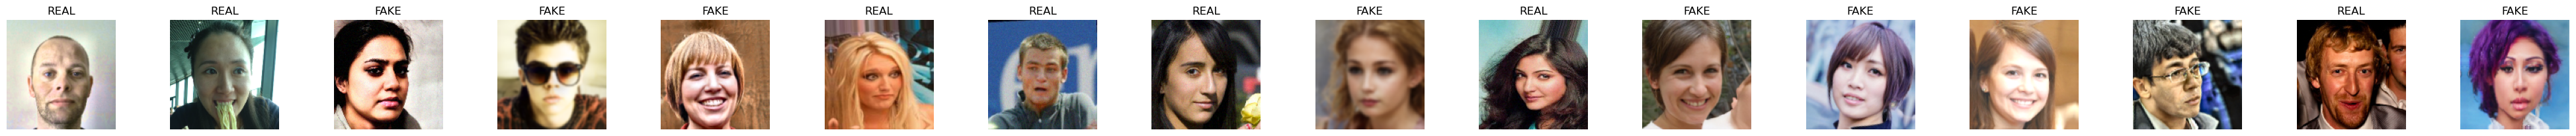

In [13]:
def imshow_with_labels(dataloader, class_names, num_images=16):
    """Display a batch of images with labels."""
    images, labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(1, num_images, figsize=(50, 50), 
                             subplot_kw={'xticks':[], 'yticks':[], 'frame_on':False})
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    for ax, img, lbl in zip(axes, images, labels):
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(class_names[lbl])
    
    plt.show()

# Using the function to display a batch
imshow_with_labels(train_loader, class_names=full_dataset.classes)

## Training

### Prepare Training

In [20]:
torch.manual_seed(42)
model = ComplexCNN().to(device)

In [15]:
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.NAdam(model.parameters(), lr=learning_rate)

NameError: name 'learning_rate' is not defined

In [16]:
writer = SummaryWriter(f'runs/Altheia_1/AutoML')
step = 0

## Define Check Accuracy Function

In [21]:
def check_accuracy(loader, model):
    print(type(loader))
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            predictions = (torch.sigmoid(scores) > 0.5).squeeze().long()
            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)
            # print(f"y shape: {y.shape}")
            # print(f"y values: {y.unique()}")
            # print(f"predictions shape: {predictions.shape}")
            # print(f"predictions values: {predictions.unique()}")

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

    
    accuracy = float(num_correct)/float(num_samples)

    model.train()

    return accuracy

# check_accuracy(train_loader, model)
# check_accuracy(test_loader, model)

In [22]:
# TODO: DOCUMENT THIS
def get_aug_name(aug):
    name_map = {
        A.Resize: "Resize",
        A.RandomBrightnessContrast: "RBC",
        A.RandomGamma: "RGamma",
        A.CLAHE: "CLAHE",
        A.HorizontalFlip: "HFlip",
        A.ShiftScaleRotate: "SSR",
        A.HueSaturationValue: "HSV",
        A.GaussNoise: "GNoise",
        A.GaussianBlur: "GBlur",
        A.OpticalDistortion: "ODist",
        A.GridDistortion: "GDist",
    }

    aug_name = []
    for transform in aug:
        if type(transform) in name_map:
            aug_name.append(name_map[type(transform)])
    return "_".join(aug_name)


### Train Model

In [23]:
from tensorboardX import SummaryWriter
from torchvision.utils import make_grid

def train_model(model, train_loader, test_loader, optimizer, writer, epochs=3):
    criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy Loss
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass
            scores = model(data)
            loss = criterion(scores.squeeze(), targets.float())

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 50 == 0:  # print every 50 batches
                print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} Loss: {loss.item()}")
                writer.add_scalar('Training Loss', loss.item(), epoch*len(train_loader) + batch_idx)

        train_acc = check_accuracy(train_loader, model)
        test_acc = check_accuracy(test_loader, model)
        
        writer.add_scalar('Train Accuracy', train_acc, epoch)
        writer.add_scalar('Test Accuracy', test_acc, epoch)

        if hasattr(model, 'name'):
            model_name = model.name
        else:
            model_name = model.__class__.__name__
        
        print(f"Model {model_name} | Learning Rate {learning_rate} | Epoch [{epoch}/{epochs}] \n Train Accuracy: {train_acc*100:.2f}% Test Accuracy: {test_acc*100:.2f}%")

# Define the accuracy checker
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            predictions = torch.sigmoid(scores).round()
            num_correct += (predictions.squeeze() == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return float(num_correct) / float(num_samples)

# Iterate over combinations
results = []

for model_class in [SimpleCNN, ComplexCNN]:
    for learning_rate in learning_rates:
        for aug in all_augmentations:
            wrapped_augmentation = AlbumentationsTransform(aug)
            train_dataset = CustomDataset(train_subset, root=root_dir, transform=wrapped_augmentation)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            
            model = model_class()
            optimizer = optim.NAdam(model.parameters(), lr=learning_rate)

            # TensorBoard Writer setup
            aug_name = get_aug_name(aug)
            writer_name = f"{model_class.__name__}_lr={learning_rate}_aug={aug_name}"
            writer = SummaryWriter(log_dir=f"runs/{writer_name}")

            # Training
            train_model(model, train_loader, test_loader, optimizer, writer, epochs=3)
            
            train_acc = check_accuracy(train_loader, model)
            test_acc = check_accuracy(test_loader, model)
            results.append((model_class.__name__, learning_rate, aug, train_acc, test_acc))

            # Close the TensorBoard writer
            writer.close()

Epoch [0/3] Batch 0/3422 Loss: 0.6768919229507446
Epoch [0/3] Batch 50/3422 Loss: 0.4662262797355652
Epoch [0/3] Batch 100/3422 Loss: 0.5007215142250061
Epoch [0/3] Batch 150/3422 Loss: 0.5821478366851807
Epoch [0/3] Batch 200/3422 Loss: 0.4650903642177582
Epoch [0/3] Batch 250/3422 Loss: 0.45493441820144653
Epoch [0/3] Batch 300/3422 Loss: 0.4747130274772644
Epoch [0/3] Batch 350/3422 Loss: 0.4553704857826233
Epoch [0/3] Batch 400/3422 Loss: 0.4303760528564453
Epoch [0/3] Batch 450/3422 Loss: 0.3879518508911133
Epoch [0/3] Batch 500/3422 Loss: 0.3787612318992615
Epoch [0/3] Batch 550/3422 Loss: 0.3459452688694
Epoch [0/3] Batch 600/3422 Loss: 0.4169408679008484
Epoch [0/3] Batch 650/3422 Loss: 0.5112180709838867
Epoch [0/3] Batch 700/3422 Loss: 0.33691948652267456
Epoch [0/3] Batch 750/3422 Loss: 0.40632057189941406
Epoch [0/3] Batch 800/3422 Loss: 0.512948751449585
Epoch [0/3] Batch 850/3422 Loss: 0.5126911401748657
Epoch [0/3] Batch 900/3422 Loss: 0.38218510150909424
Epoch [0/3] Bat

KeyboardInterrupt: 

> Use this for documentation. Indented blocks

## Testing the Model